This notebook demonstrates my winning solution for the Santa 2025 competition. See also the writeup here: XXX

To allow it to run in the Kaggle environment, it runs only a few tree combinations, covering the various solution flavors used. The full winning submission involved more steps, many of them manual:
- Rerun each number of trees several times for different configurations (symmetric vs asymmetric, tesselated vs free) and seeds.
- An additional 'exploit' step in which the best solutions from multiple runs for the same number of trees are combined in their own genetic algorithm.
- An additional compression step performed in float64 (instead of float32 as this notebook does) to squeeze out some decimal dust.
- Using a few manually built crystal solutions (some of them taken from public notebooks).

This means that the current notebook may not reproduce scores as good as my submission, particularly for high numbers of trees.

If you do want to run this for real, the most cost- and energy-efficient GPU to use is an RTX 5090. Including multiprocessing tricks, it could run the solvers in this notebook in well under an hour.

In [1]:
# Set up path and load core modules
import sys
import os
sys.path.insert(0, '/mnt/d/packing/code/core/')
import kaggle_support as kgs
import pack_ga3
import pack_io
import pandas as pd
import pack_vis_sol
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

Detected environment: local


In [2]:
# Read in the best solutions - this will be used in modes 4 and 5 only (see "solve" below)
# I used these modes for odd numbers of trees - they use the solutions already found for even numbers of trees
best_solutions,_ = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.submission_csv_path))

# Define the solver
def solve(num_trees:int, mode:int, seed:int=42) -> kgs.SolutionCollection:
    """Create and configure a GA runner for packing `num_trees`."""
    """
    This helper selects and configures a `pack_ga3` runner according to
    the `mode` argument, optionally seeding it from previously saved
    solutions. 

    Parameters:
    - num_trees (int): number of trees to pack.
    - mode (int): solver mode selector. Allowed values:
        0 : asymmetric
        1 : 180 degrees symmetric
        2 : 180 degrees symmetric, tesselated
        3 : 180 degrees symmetric, tesselated with half-cell offset
        4 : asymmetric, seed from N-1 solution
        5 : asymmetric, seed from N+1 solution
        6 : 90 degrees symmetric
    - seed (int): RNG seed for the genetic algorithm runner.

    Returns the packed configuration (as a kgs.SolutionCollection).
    """
    # Mode 0: asymmetric
    # Mode 1: 180 degrees symmetric
    # Mode 2: 180 degrees symmetric, tesselated
    # Mode 3: 180 degrees symmetric, tesselated with half-cell offset
    # Mode 4: asymmetric, use N-1 solution as seed
    # Mode 5: asymmetric, use N+1 solution as seed
    # Mode 6: 90 degrees symmetric - not used in my submission, but makes some cool solutions    

    match mode:
        case 0:
            runner = pack_ga3.baseline()
        case 1:
            runner = pack_ga3.baseline_symmetry_180()
        case 2:
            runner = pack_ga3.baseline_symmetry_180_tesselated()
            # Set the Y position of the crystal
            runner.ga.ga_base.initializer.ref_sol_axis2_offset = lambda r:0.
        case 3:
            runner = pack_ga3.baseline_symmetry_180_tesselated()
            # Set the Y position of the crystal, offset by half a cell
            runner.ga.ga_base.initializer.ref_sol_axis2_offset = lambda r:0.5
        case 4:
            runner = pack_ga3.baseline_tesselated()       
            runner.ga.ga_base.initializer.ref_sol_crystal_type = None   
            # Set seed solutions; the inner part will be used, effectively seeding the crystal
            runner.ga.ga_base.initializer.ref_sol = best_solutions[num_trees-2]
        case 5:
            runner = pack_ga3.baseline_tesselated()       
            runner.ga.ga_base.initializer.ref_sol_crystal_type = None     
            # Set seed solutions; the inner part will be used, effectively seeding the crystal
            runner.ga.ga_base.initializer.ref_sol = best_solutions[num_trees]
        case 6:
            runner = pack_ga3.baseline_symmetry_90()
        case _:
            raise ValueError("Invalid mode")
        
    runner.ga.ga_base.N_trees_to_do = num_trees
    runner.diagnostic_plot = True  # Show diagnostic plots
    runner.seed = seed   # Set random seed
    runner.use_atomic_save = True  # Enable atomic saves for multiprocess safety
    runner.filename = f'ga_N{num_trees}_seed{seed}' # Output intermediate results for visualization
    runner.plot_every = 20 # Diagnostic plots every 20 iterations
    runner.ga.stop_check_generations_scale = 1 # Stop sooner if no improvement (just to speed up this notebook)


    # Off we go!
    runner.run()

    # Show the final diagnostic plot    
    clear_output(wait=True)  # Clear previous output          
    runner.ga.diagnostic_plots(runner._current_generation, None)  
    plt.close('all')

    # Show the solution, and compare it to the submitted one
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0])
    pack_vis_sol.pack_vis_sol(runner.ga.champions[0].phenotype, ax=ax[0])
    plt.title(f'Solution generated just now, score={runner.ga.champions[0].phenotype.h[0,0].get()**2/num_trees:.6f}')
    plt.sca(ax[1])
    pack_vis_sol.pack_vis_sol(best_solutions[num_trees-1], ax=ax[1])
    plt.title(f'Solution from winning submission, score={best_solutions[num_trees-1].h[0,0].get()**2/num_trees:.6f}')
    
                    

### 7 trees - free configuration

Let's start with a simple run - 7 trees, which has the most basic pattern (no specific symmetries). This first run may take a while to get going due to the need to construct the lookup table for the separation function.

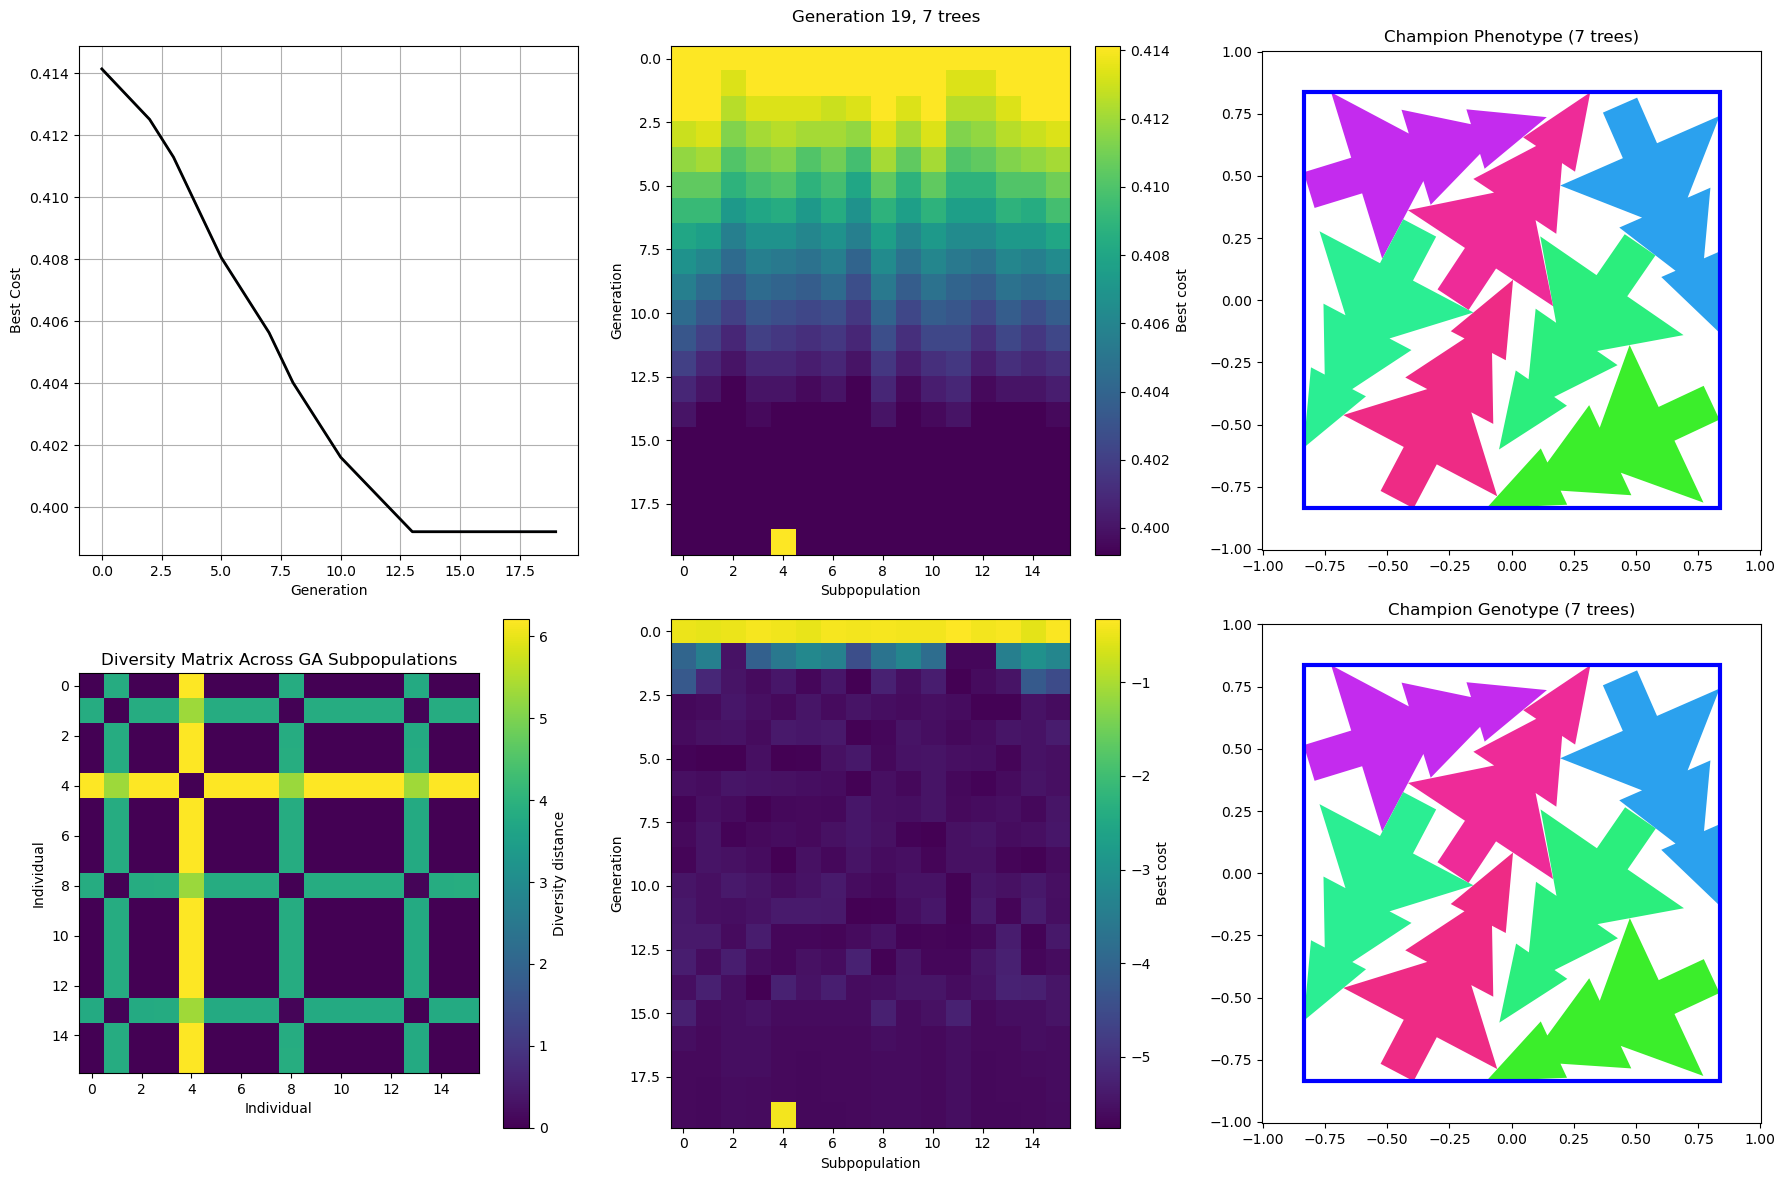

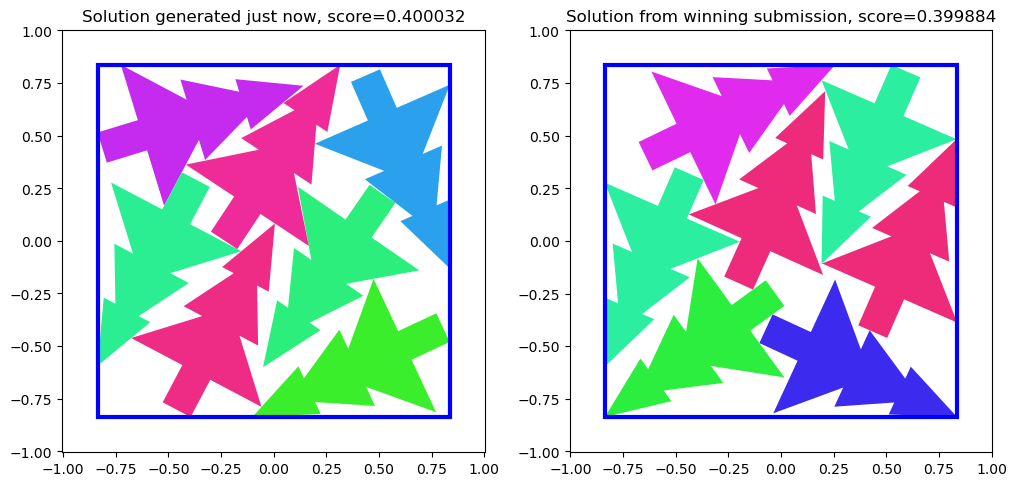

In [3]:
solve(7, 0)

There's a lot to see here. First, consider the two figures on the bottom. We see that the solution we just generated scores a bit worse than the one in the winning submission - it's actually optimal, but needs a bit more decimal dust removal in float64. We don't do that in this notebook because switching between float32 and float64 is messy.

Next, consider the six figures at the top. The top left figure shows the best score as function of the number of genetic-algorithm (GA) iterations. Note that in this case we quickly converge to the correct solution, and spend a long time waitin for futher improvements which don't come; at higher number of trees, the improvements are much more gradual. 

The top middle figure shows the score for each of the 16 islands of the GA as a function of time (Y axis). Each of these islands houses a population of individuals, which can mate with each other and with individuals from nearby islands. Note that the score often resets; this happens when an island has not improved for a while. 

The bottom middle figure shows how much overlap there is between the trees for each island. Whenever the overlap falls under a certain threshold, the size of the square decreases (and so the score in the top middle decreases). Note that this means that the individuals are typically not legal solutions - they're legalized (brought to zero overlap) at the end in a separate step.

The bottom left figure shows the genetic diversity between the islands - low (blue) values indicate the champions of each island are very similar (up to rotation and mirroring). In this case we can see that there are two main solutions active; these actually have very similar score but are not identical.

Finally, the top right figure shows the best solution so far. The bottom right figure shows the same - for now.

### 22 trees - 180 degree symmetry

Let's move on to a new case: 22 trees. Here, we'll look specifically for a solution with 180 degree symmetry (mode 1).

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx900_Ny900_Nt900_trimTrue_tree42d0f17d.lut_cache...
Successfully loaded cached lookup table


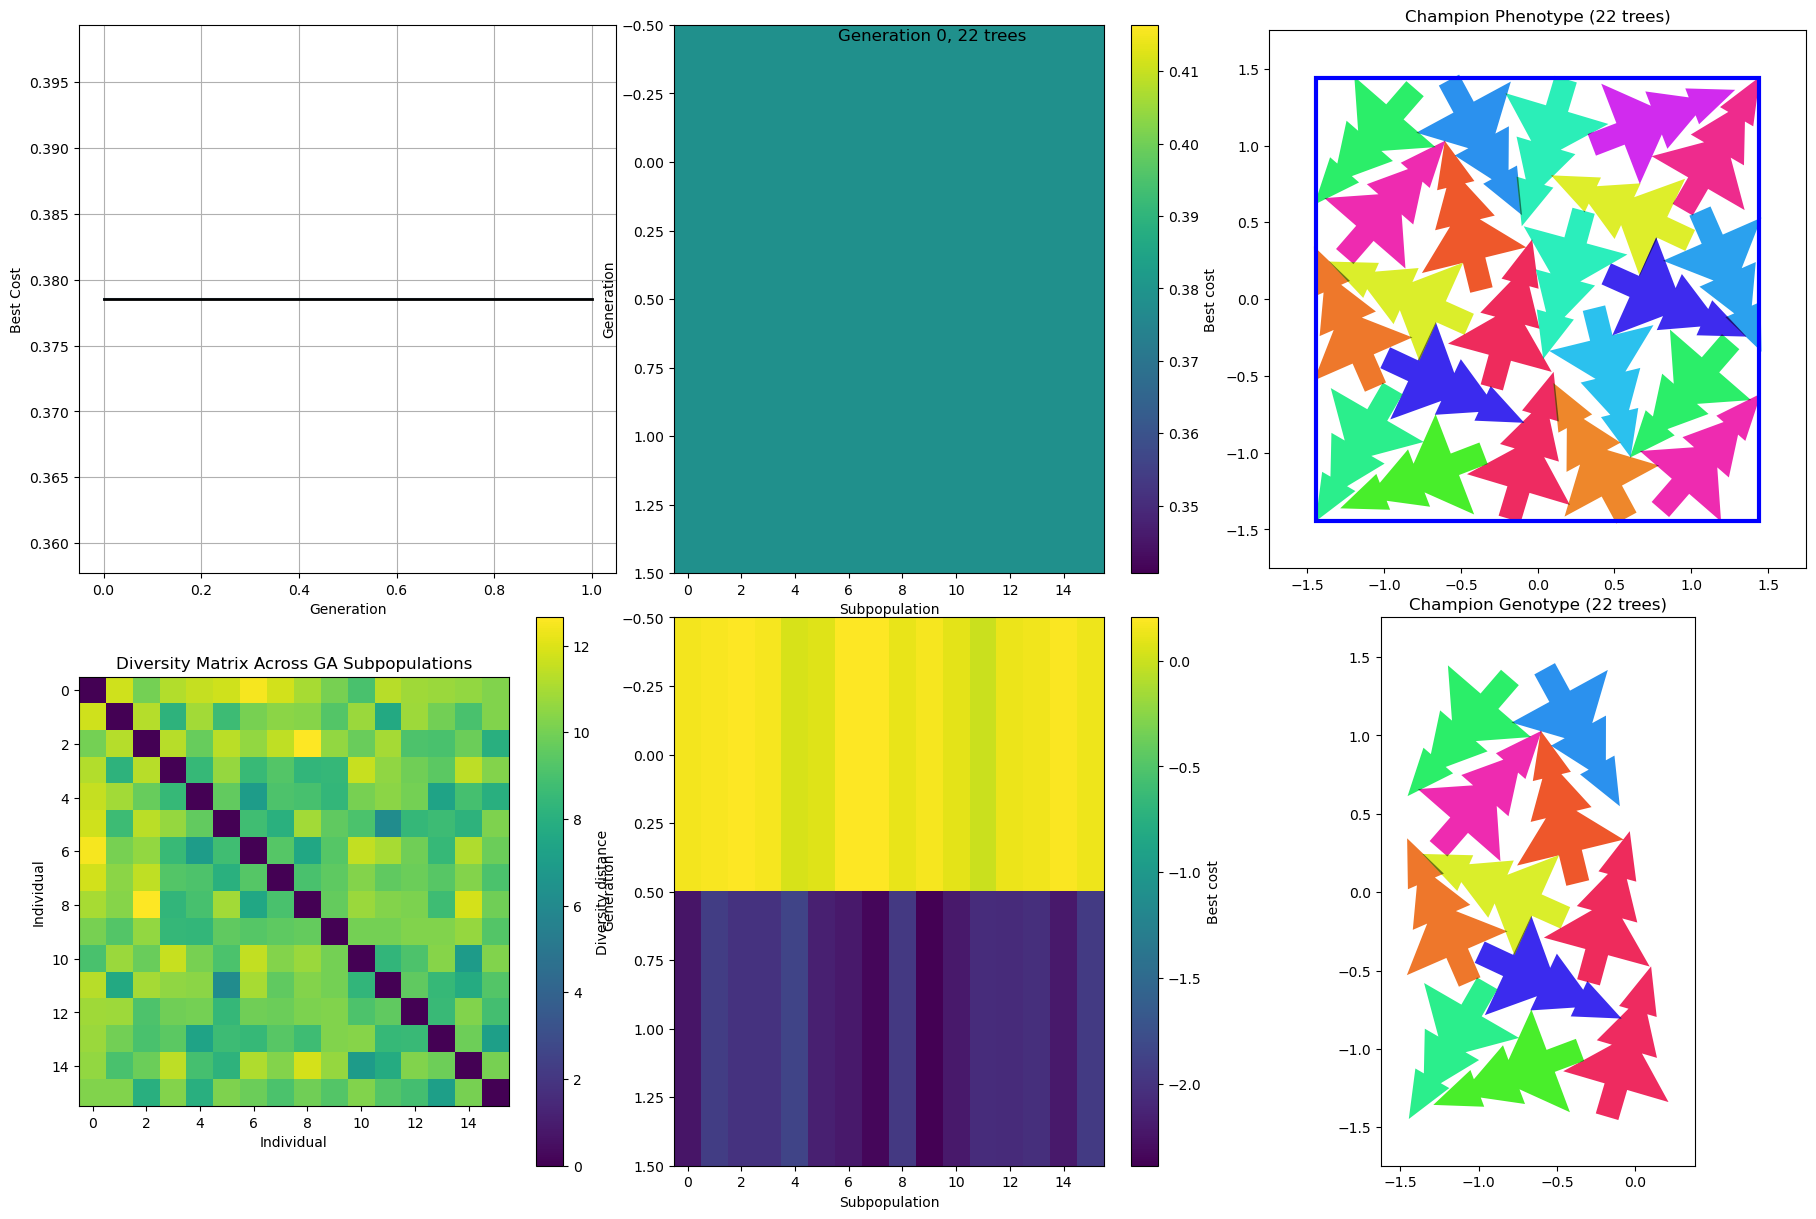

In [ ]:
solve(22, 1)

Note that the top right and bottom right figures in the upper half (phenotype and genotype) are not identical now. When we enable 180 degree symmetry, only half the trees are position in the genotype. For the phenotype, the other half of the trees are positioned based on the 180 degree images of the genotype.

Note also in the genetic diversity plot that neighboring islands tend to be more similar than far-away islands - this is due to the local mating rules.

It's also clearly visible in the top middle figure that the champion island is not being reset.

### 60 trees - 180 degree symmetry with crystal seed

For higher numbers of trees, it generally pays to start from a tesselated core. The GA struggles to find these solutions unaided.

All crystal seeds use the optimal packing tesselation. But we still need to position it properly - there are 4 possible shifts of the lattice that respect the symmetry. We choose the Y shift explicitly (mode 2 vs 3), and use both X shifts during the GA (selected randomly for each starting individual).

In [ ]:
solve(60,2)

### 59 trees - asymmetric with crystal seed

For an odd number of trees, we can't use the 180 degree symmetry. But it still pays to use a crystal seed. Rather than messing around with figuring out the crystal shift, we copy the inner part of the solution from N-1 or N+1.

In [ ]:
solve(59,5)

### 48 trees - 90 degree symmetry

As a bonus, we can also use 90 degree symmetry rather than 180 degree symmetry, i.e. specifying only N/4 trees. Unfortunately this didn't lead to any optimal solutions (although it gets close, as in this 48 tree example). But it does lead to some very attractive ones.

In [ ]:
solve(48,6)